In [1]:
import pandas as pd
from numpy.linalg import inv
import math
import numpy as np

scene_num = 11111111


#detection_result = '00{:02d}.txt'.format(scene_num)
#detection_result_oxts = 'oxts//'+detection_result
#detection_result_calib= 'calib//'+detection_result

result_dir = 'result_lyft'
detection_result = result_dir+'//test//0000.txt'
detection_result_oxts = result_dir+'//oxts.txt'
detection_result_calib = result_dir+'//calib.txt'


# x: sideward
# y: downward
# z: forward
detection_data = pd.read_csv(detection_result, sep=" ", header=None)
detection_data.columns = ["FrameID", "ObjectID", "Type", "Truncation","Occlusion","Alpha","BBox-1","BBox-2","BBox-3","BBox-4","Dim-l","Dim-w","Dim-h","Loc-x","Loc-y","Loc-z","Rot","Score"]

detection_oxts = pd.read_csv(detection_result_oxts, sep=" ", header=None)


print(detection_oxts)

           0         1          2         3         4         5   6   7   \
0    0.008294  0.020944 -19.868025  0.020600  0.003332  2.593655   0   0   
1    0.008307  0.020923 -19.880460  0.021165  0.003032  2.594849   0   0   
2    0.008320  0.020902 -19.816611  0.019814 -0.000443  2.598092   0   0   
3    0.008333  0.020880 -19.808399  0.017129 -0.000115  2.598512   0   0   
4    0.008345  0.020858 -19.841960  0.014660  0.000565  2.599063   0   0   
..        ...       ...        ...       ...       ...       ...  ..  ..   
120  0.009850  0.018432 -19.377031  0.014278 -0.001711  2.583019   0   0   
121  0.009863  0.018411 -19.353782  0.013223  0.000222  2.581299   0   0   
122  0.009876  0.018390 -19.327169  0.012375 -0.002251  2.579185   0   0   
123  0.009889  0.018369 -19.303575  0.012920 -0.001361  2.577598   0   0   
124  0.009903  0.018348 -19.327252  0.015949 -0.000267  2.577130   0   0   

            8   9   ...  20  21  22  23  24  25  26  27  28  29  
0    13.509306   0  .

In [2]:
#read calib file

f = open(detection_result_calib, "r")
p0_raw = f.readline()
p1_raw = f.readline()
p2_raw = f.readline()
p3_raw = f.readline()
r_rect_raw = f.readline()
tr_velo_cam_raw = f.readline()
tr_imu_velo_raw = f.readline()



tr_imu_velo = list(map(float,tr_imu_velo_raw[11:].split()))
tr_velo_cam = list(map(float,tr_velo_cam_raw[11:].split()))
tr_imu_velo = np.reshape(tr_imu_velo, (3, 4))
tr_velo_cam = np.reshape(tr_velo_cam, (3, 4))

tr_imu_velo = np.vstack((tr_imu_velo, [0, 0, 0, 1]))
tr_velo_cam = np.vstack((tr_velo_cam, [0, 0, 0, 1]))


tr_imu_cam = tr_velo_cam.dot(tr_imu_velo)#tr_imu_velo.dot(tr_velo_cam)

tr_cam_imu = inv(tr_imu_cam)
print('Calibration Matrix:')
print(tr_cam_imu)

FileNotFoundError: [Errno 2] No such file or directory: 'result_lyft//calib.txt'

In [ ]:
#transfer tracks to global coordinates
#cam  -> oxts ->global 
#  Tr_imu_velo*Tr_velo_cam -> Tr_imu_cam = Tr_cam_imu ^-1


def rotx(t):
    """Rotation about the x-axis."""
    c = np.cos(t)
    s = np.sin(t)
    return np.array([[1,  0,  0],
                     [0,  c, -s],
                     [0,  s,  c]])


def roty(t):
    """Rotation about the y-axis."""
    c = np.cos(t)
    s = np.sin(t)
    return np.array([[c,  0,  s],
                     [0,  1,  0],
                     [-s, 0,  c]])


def rotz(t):
    """Rotation about the z-axis."""
    c = np.cos(t)
    s = np.sin(t)
    return np.array([[c, -s,  0],
                     [s,  c,  0],
                     [0,  0,  1]])

def transform_from_rot_trans(R, t):
    """Transforation matrix from rotation matrix and translation vector."""
    R = R.reshape(3, 3)
    t = t.reshape(3, 1)
    return np.vstack((np.hstack([R, t]), [0, 0, 0, 1]))



scale = np.cos(detection_oxts.iloc[0,0]*np.pi/180)


origin = None


pose_mat = []
ego_coords = []
Tr_0_inv = None
for index, row in detection_oxts.iterrows():
    #if row empty-> continue
    
    t = []
    
    er = 6378137.  # earth radius (approx.) in meters
    tx = scale * row[1] * np.pi * er / 180.
    ty = scale * er * np.log(np.tan((90. + row[0]) * np.pi / 360.))
    tz = row[2]
    t = np.array([tx, ty, tz])
    
    
    rx = row[3]; # roll
    ry = row[4]; # pitch
    rz = row[5]; # yaw 
    
    Rx = rotx(rx)
    Ry = roty(ry)
    Rz = rotz(rz)
    
    R  = Rz.dot(Ry.dot(Rx))
    
    if origin is None:
        origin = t
    
    if Tr_0_inv is None:
        Tr_0_inv = inv(transform_from_rot_trans(R, t))
        
    pose_mat.append((transform_from_rot_trans(R, t-origin).dot(tr_cam_imu)))
    #pose_mat.append(tr_cam_imu.dot(Tr_0_inv.dot(transform_from_rot_trans(R, t))))
    #pose_mat.append(tr_imu_cam.dot(transform_from_rot_trans(R, t-origin)))
    #pose_mat.append(Tr_0_inv.dot(transform_from_rot_trans(R, t)).dot(tr_cam_imu))
    ego_coords.append(t-origin)
ego_coords = np.array(ego_coords)

In [ ]:
index = range(max(detection_data['FrameID'])+1)
columns = ["Car "+str(x) for x in range(max(detection_data['ObjectID'])+1)]

traffic_coords = pd.DataFrame(index=index, columns=columns)
traffic_coords = traffic_coords.astype(object)

#x:sideward
#y:forward
#z:upward


ego_coords2 = []
for index, row in detection_oxts.iterrows():
    ego_coords2.append(pose_mat[index].dot([10,0,0,1]).tolist())

ego_coords2 = np.array(ego_coords2)
  


ego_vel = detection_oxts.iloc[ : , 8 ]
for index, row in detection_data.iterrows():
    T_pose = pose_mat[row['FrameID']]
    point = np.array([row['Loc-x'],row['Loc-y'],row['Loc-z'],1])
    point = T_pose.dot(point)    
    traffic_coords.at[row['FrameID'], 'Car '+str(row['ObjectID'])] = point.tolist()


print(traffic_coords)






<IPython.core.display.Javascript object>


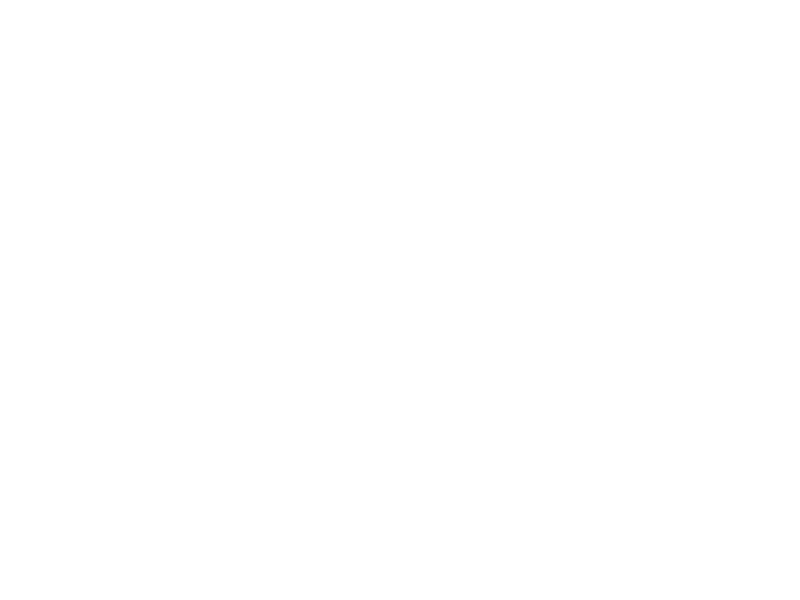

0-Range:-128.01118727388584 - -9.485474611475803
1-Range:-237.14970612860955 - 4.147601471192709
2-Range:0.7275361914264624 - 1.102066735571422


In [5]:
#plot results

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d    

%matplotlib notebook

fig = plt.figure()
ax = plt.axes(projection="3d")


x_line = ego_coords[:,0]
y_line = ego_coords[:,1]
z_line = ego_coords[:,2]


x_line2 = ego_coords2[:,0]
y_line2 = ego_coords2[:,1]
z_line2 = ego_coords2[:,2]


print('0-Range:'+str(min(ego_coords2[:,0]))+" - "+str(max(ego_coords2[:,0])))
print('1-Range:'+str(min(ego_coords2[:,1]))+" - "+str(max(ego_coords2[:,1])))
print('2-Range:'+str(min(ego_coords2[:,2]))+" - "+str(max(ego_coords2[:,2])))



counter = 0

for column in traffic_coords:
    counter += 1
    if counter < 0:
        continue
    elif counter > 50:
        break
    car = traffic_coords[column]
    x_traff = []
    y_traff = []
    z_traff = []
    for index in range(len(car)):
        if type(car[index]) is list:
            x_traff.append(car[index][0])
            y_traff.append(car[index][1])
            z_traff.append(car[index][2])
        ax.plot3D(x_traff, y_traff, z_traff, 'blue')

ax.plot3D(x_line,y_line,z_line, 'gray')
ax.plot3D(x_line2,y_line2,z_line2, 'green')


# make labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#ax.auto_scale_xyz([-800, 0], [-800 ,0], [-100, 100])

plt.show()


In [ ]:
#filter short occurence traffic


for index,entrys in traffic_coords.count().iteritems():
    if entrys < 5:
        traffic_coords.drop(index,axis=1,inplace=True)
        
        
#append rotation rz to data

#at least 2 rows in row!

for col_index,col in enumerate(traffic_coords):
    car_col = traffic_coords[col]
    for index,coords in car_col.items(): 
        if type(coords) is list and len(traffic_coords.index) > index+1 and type(car_col[index+1]) is list:
            dx=coords[0]-car_col[index+1][0]
            dy=coords[1]-car_col[index+1][1]
            rz = math.atan2(dy, dx)-np.pi
            traffic_coords.at[index, col].extend([rz])
        elif type(coords) is list:
            traffic_coords.at[index, col].extend([rz])
            
            

prev_coords = []
ego_rz = np.zeros(shape=(len(ego_coords),1))
for index,coords in enumerate(ego_coords): 
    if index == 0:
        prev_coords = coords
        #ego_rz.append(0)
        continue 
        
    dx=prev_coords[0]-coords[0]
    dy=prev_coords[1]-coords[1]
    rz = math.atan2(dy, dx)-np.pi
    
    ego_rz[index] = rz
    prev_coords = coords
           
        
        
      
    
ego_coords = np.append(ego_coords, ego_rz, axis=1)


In [ ]:
CM_PROJECT_DIR = 'C://CM_Projects//maneuver_simu'
TESTRUN_DIR = CM_PROJECT_DIR+'//Data//TestRun'
SIMINPUT_DIR = CM_PROJECT_DIR+'//SimInput'

TESTRUN_ID=scene_num
TESTRUN_NAME = TESTRUN_DIR+'//testrun_%d'%TESTRUN_ID
TRAFFIC_PROFILE_NAME = SIMINPUT_DIR+'//traffic_profile_%d.txt'%TESTRUN_ID
EGO_PROFILE_NAME = SIMINPUT_DIR+'//ego_profile_%d.txt'%TESTRUN_ID


content_lines = []
content_lines.append('#INFOFILE1.1 - Do not remove this line!\n\
FileIdent = CarMaker-TestRun 8\n\
FileCreator = CarMaker 8.1 2019-11-07\n\
Description:\n\
Vehicle = Demo_Toyota_Camry\n\
Trailer =\n\
Tire.0 =\n\
Tire.1 =\n\
Tire.2 =\n\
Tire.3 =\n\
Snapshot.TimeLimit =\n\
Snapshot.DistLimit =\n\
VehicleLoad.0.mass = 0\n\
VehicleLoad.0.pos = 0 0 0\n\
VehicleLoad.1.mass = 0\n\
VehicleLoad.1.pos = 0 0 0\n\
VehicleLoad.2.mass = 0\n\
VehicleLoad.2.pos = 0 0 0\n\
VehicleLoad.3.mass = 0\n\
VehicleLoad.3.pos = 0 0 0\n\
TrailerLoad.0.mass = 0\n\
TrailerLoad.0.pos = 0 0 0\n\
TrailerLoad.1.mass = 0\n\
TrailerLoad.1.pos = 0 0 0\n\
TrailerLoad.2.mass = 0\n\
TrailerLoad.2.pos = 0 0 0\n')
                     
#ego maneuver for every 10th coord

time_between_records = 0.1 

start_vel = ego_vel[0]
man_counter = 1
#ego_man = []
#for vel in ego_vel[::10]:
#    ego_man.append('DrivMan.'+str(man_counter)+'.TimeLimit = '+str(10*time_between_records)+'\n\
#DrivMan.'+str(man_counter)+'.LongDyn = VelControl '+str(vel*3.6)+' 0.0 1.0 0 1 0\n\
#DrivMan.'+str(man_counter)+'.LatDyn = Driver 0\n')
#    man_counter += 1
    
       # +str(start_vel)+
content_lines.append('DrivMan.Init.Velocity = 0\n\
DrivMan.Init.SteerAng = 0\n\
DrivMan.Init.GearNo = 0\n\
DrivMan.Init.LaneOffset = 0\n\
DrivMan.Init.OperatorActive = 1\n\
DrivMan.Init.OperatorState = drive\n\
DrivMan.VhclOperator.Kind = IPGOperator 1\n\
DrivMan.nDMan = '+str(man_counter)+'\n')

content_lines.append('DrivMan.0.TimeLimit = '+str(time_between_records*(len(ego_coords)-1))+'\n\
DrivMan.0.LongDyn = Stop 2.0 0\n\
DrivMan.0.LatDyn = Driver 0\n')


#for line in ego_man:
#    content_lines.append(line)
    
    
#write traffic profile file

traffic_profile = []
traffic_profile.append('# Time')
for index,col in enumerate(traffic_coords):
    traffic_profile.append(' FM_tx_%d FM_ty_%d FM_tz_%d FM_rz_%d' % (index,index,index,index))
traffic_profile.append('\n')    


prev_row = None
for time_index, row in traffic_coords.iterrows():
    traffic_profile.append('%f'%(time_index*time_between_records))
    
    for car_index,coords in enumerate(row): 
        if type(coords) is list:
            traffic_profile.append(' %f %f %f %f'%(coords[0],coords[1],1,coords[4]))
        else:
            traffic_profile.append(' %f %f %f %f'%(0,0,-100,0))
    
    prev_row = row
    traffic_profile.append('\n') 
    

    
with open(TRAFFIC_PROFILE_NAME, 'w') as f:
    for item in traffic_profile:
        f.write("%s" % item)


traffic_counter = 0   
traffic_counter = len(traffic_coords.columns)
content_lines.append('Traffic.IFF.FName = '+TRAFFIC_PROFILE_NAME+'\n\
Traffic.IFF.Time.Name = Time\n\
Traffic.N = %d\n\
Traffic.SpeedUnit = ms\n'%traffic_counter)
    

for index,col in enumerate(traffic_coords):    
    content_lines.append('Traffic.'+str(index)+'.ObjectKind = Movable\n\
Traffic.'+str(index)+'.ObjectClass = Car\n\
Traffic.'+str(index)+'.Name = T'+str(index)+'\n\
Traffic.'+str(index)+'.Info = UNNAMED Object '+str(index)+'\n\
Traffic.'+str(index)+'.Movie.Geometry = 3D/Vehicles/VW_Beetle_2012_Blue.mobj\n\
Traffic.'+str(index)+'.Color = 1.0 0.0 0.0\n\
Traffic.'+str(index)+'.Basics.Dimension = 4.28 1.82 1.28\n\
Traffic.'+str(index)+'.Basics.Offset = 0.0 0.0\n\
Traffic.'+str(index)+'.Basics.Fr12CoM = 2.15\n\
Traffic.'+str(index)+'.Init.Orientation = 0.0 0.0 0.0\n\
Traffic.'+str(index)+'.RCSClass = RCS_Car\n\
Traffic.'+str(index)+'.DetectMask = 1 1\n\
Traffic.'+str(index)+'.Route = 0 1\n\
Traffic.'+str(index)+'.Init.Road = 18 R2\n\
Traffic.'+str(index)+'.Init.v = 1\n\
Traffic.'+str(index)+'.FreeMotion = 1\n\
Traffic.'+str(index)+'.UpdRate = 200\n\
Traffic.'+str(index)+'.IFF.FM_tx.Name =FM_tx_'+str(index)+'\n\
Traffic.'+str(index)+'.IFF.FM_tx.Factor = 1.0\n\
Traffic.'+str(index)+'.IFF.FM_tx.Offset = 0.0\n\
Traffic.'+str(index)+'.IFF.FM_ty.Name =FM_ty_'+str(index)+'\n\
Traffic.'+str(index)+'.IFF.FM_ty.Factor = 1.0\n\
Traffic.'+str(index)+'.IFF.FM_ty.Offset = 0.0\n\
Traffic.'+str(index)+'.IFF.FM_tz.Name =FM_tz_'+str(index)+'\n\
Traffic.'+str(index)+'.IFF.FM_tz.Factor = 1.0\n\
Traffic.'+str(index)+'.IFF.FM_tz.Offset = 0.0\n\
Traffic.'+str(index)+'.IFF.FM_rx.Name =\n\
Traffic.'+str(index)+'.IFF.FM_rx.Factor = 1.0\n\
Traffic.'+str(index)+'.IFF.FM_rx.Offset = 0.0\n\
Traffic.'+str(index)+'.IFF.FM_ry.Name =\n\
Traffic.'+str(index)+'.IFF.FM_ry.Factor = 1.0\n\
Traffic.'+str(index)+'.IFF.FM_ry.Offset = 0.0\n\
Traffic.'+str(index)+'.IFF.FM_rz.Name =FM_rz_'+str(index)+'\n\
Traffic.'+str(index)+'.IFF.FM_rz.Factor = 1.0\n\
Traffic.'+str(index)+'.IFF.FM_rz.Offset = 0.0\n')

                     
#pointlist start degree
dx = ego_coords[1][0]-ego_coords[0][0]
dy = ego_coords[1][1]-ego_coords[0][1]

startDeg = math.degrees(math.atan2(dy, dx))

#pointlist end vector
dx = ego_coords[-1][0]-ego_coords[-2][0]
dy = ego_coords[-1][1]-ego_coords[-2][1]

content_lines.append('DrivMan.OW.Active = 1\n\
DrivMan.OW.Quantities = Time User1 User2 User3 User4\n\
DrivMan.OW.StartGearNo = 1\n\
DrivMan.OW.StartVelocity =\n\
DrivMan.OW.GasMax = 0.5\n\
DrivMan.OW.RefCh = Time\n\
DrivMan.OW.ConsiderRoadSigns = 0\n\
DrivMan.OW.sRoute.Offset = 0\n\
DrivMan.OW.Time.Name = t[s]\n\
DrivMan.OW.Time.Factor = 1.0\n\
DrivMan.OW.User1.Name = tx\n\
DrivMan.OW.User1.Factor = 1.0\n\
DrivMan.OW.User1.Offset = 0.0\n\
DrivMan.OW.User2.Name = ty\n\
DrivMan.OW.User2.Factor = 1.0\n\
DrivMan.OW.User2.Offset = 0.0\n\
DrivMan.OW.User3.Name = vx\n\
DrivMan.OW.User3.Factor = 1.0\n\
DrivMan.OW.User3.Offset = 0.0\n\
DrivMan.OW.User4.Name = vy\n\
DrivMan.OW.User4.Factor = 1.0\n\
DrivMan.OW.User4.Offset = 0.0\n\
DrivMan.OW.FName = ego_profile_'+str(TESTRUN_ID)+'.txt\n\
ErrorClass.0.Action = abort\n\
ErrorClass.0.Save = 0\n\
ErrorClass.0.WarningLimit = 3 5\n\
ErrorClass.1.Action = abort\n\
ErrorClass.1.Save = 0\n\
ErrorClass.1.WarningLimit = 3 5\n\
ErrorClass.2.Action = abort\n\
ErrorClass.2.Save = 0\n\
ErrorClass.2.WarningLimit = 3 5\n\
ErrorClass.3.Action = abort\n\
ErrorClass.3.Save = 0\n\
ErrorClass.3.WarningLimit = 3 5\n\
ErrorClass.4.Action = abort\n\
ErrorClass.4.Save = 0\n\
ErrorClass.4.WarningLimit = 3 5\n\
ErrorClass.5.Action = abort\n\
ErrorClass.5.Save = 0\n\
ErrorClass.5.WarningLimit = 3 5\n\
ErrorClass.6.Action = abort\n\
ErrorClass.6.Save = 0\n\
ErrorClass.6.WarningLimit = 10 5\n\
ErrorClass.7.Action = abort\n\
ErrorClass.7.Save = 0\n\
ErrorClass.7.WarningLimit = 3 5\n\
ErrorClass.10.Action = abort\n\
ErrorClass.10.Save = 0\n\
ErrorClass.10.WarningLimit = 3 5\n\
ErrorClass.11.Action = abort\n\
ErrorClass.11.Save = 0\n\
ErrorClass.11.WarningLimit = 3 5\n\
Road.FileIdent = IPGRoad 8.0\n\
Road.LibVersion = 8.1\n\
Road.Country = DEU\n\
Road.nLinks = 1\n\
Road.nJunctions = 0\n\
Road.nObjects = 149\n\
Road.nRoutes = 1\n\
Road.RoadNetworkLength = 595.296984550432\n\
Road.BBox = -19.5668198180623 547.415304391587 -224.837648089968 34.6179698226834 -11 11\n\
Road.Route.0.Length = 595.296984550432\n\
Road.RST.Unit = kmh\n\
Road.RST = 50 100 130 30 70 30 0 -1\n\
Road.Movie = 0.2 1 0.01 1.5 1.5 1 1\n\
Road.PathMode = -1\n\
Road.Link.0.ID = 0\n\
Road.Link.0.Junctions = -1 -1 -2 -1\n\
Road.Link.0.Node0 = 0 0 0 '+str(startDeg)+'\n\
Road.Link.0.RST = countryroad\n\
Road.Link.0.RL.ID = 1\n\
Road.Link.0.Seg.0.ID = 5\n\
Road.Link.0.Seg.0.Type = PointList\n\
Road.Link.0.Seg.0.Param =  '+str(dx)+' '+str(dy)+' 1 0 0 0 0 0\n\
Road.Link.0.Seg.0.PointList:\n')

#append road pointlist
obj_id=5
pointlist = []
pointlist.append('# t[s] tx ty vx vy\n')
counter = 0
for row in ego_coords[::1]:
    pointlist.append('  %f %f %f %f %f\n'%(counter*time_between_records,row[0],row[1],0,0))
    counter += 1

    
with open(EGO_PROFILE_NAME, 'w') as f:
    for item in pointlist:
        f.write("%s" % item)
        
        
pointlist = ''
for row in ego_coords[::1]:
    obj_id +=  1
    pointlist = pointlist + '	'+str(row[0])+' '+str(row[1])+'\n'
    
content_lines.append(pointlist)    
    
content_lines.append('Road.Link.0.LaneSection.0.ID = '+str(obj_id+1)+'\n\
Road.Link.0.LaneSection.0.Start = 0\n\
Road.Link.0.LaneSection.0.LaneL.0.ID = '+str(obj_id+2)+'\n\
Road.Link.0.LaneSection.0.LaneL.0 = 0 3.5 3.5 0 0 0 0\n\
Road.Link.0.LaneSection.0.LaneL.0.ARP = '+str(obj_id+5)+' '+str(obj_id+6)+' '+str(obj_id+7)+' '+str(obj_id+8)+' '+str(obj_id+9)+' '+str(obj_id+10)+'\n\
Road.Link.0.LaneSection.0.LaneL.1.ID = '+str(obj_id+13)+'\n\
Road.Link.0.LaneSection.0.LaneL.1 = 0 0.75 0.75 4 0 0 0\n\
Road.Link.0.LaneSection.0.LaneL.1.ARP = '+str(obj_id+16)+' '+str(obj_id+17)+' '+str(obj_id+18)+' '+str(obj_id+19)+' '+str(obj_id+20)+' '+str(obj_id+21)+'\n\
Road.Link.0.LaneSection.0.LaneL.2.ID = '+str(obj_id+24)+'\n\
Road.Link.0.LaneSection.0.LaneL.2 = 0 1.5 1.5 4 0 0 0\n\
Road.Link.0.LaneSection.0.LaneL.2.ARP = '+str(obj_id+27)+' '+str(obj_id+28)+' '+str(obj_id+29)+' '+str(obj_id+30)+' '+str(obj_id+31)+' '+str(obj_id+32)+'\n\
Road.Link.0.LaneSection.0.LaneL.3.ID = '+str(obj_id+34)+'\n\
Road.Link.0.LaneSection.0.LaneL.3 = 0 1.5 1.5 4 0 0 0\n\
Road.Link.0.LaneSection.0.LaneL.3.ARP = '+str(obj_id+37)+' '+str(obj_id+38)+' '+str(obj_id+39)+' '+str(obj_id+40)+' '+str(obj_id+41)+' '+str(obj_id+51)+'\n\
Road.Link.0.LaneSection.0.LaneL.4.ID = '+str(obj_id+44)+'\n\
Road.Link.0.LaneSection.0.LaneL.4 = 0 0.75 0.75 4 0 0 0\n\
Road.Link.0.LaneSection.0.LaneL.4.ARP = '+str(obj_id+47)+' '+str(obj_id+48)+' '+str(obj_id+49)+' '+str(obj_id+50)+' '+str(obj_id+51)+' '+str(obj_id+52)+'\n\
Road.Link.0.LaneSection.0.LaneL.5.ID = '+str(obj_id+55)+'\n\
Road.Link.0.LaneSection.0.LaneL.5 = 0 3.5 3.5 0 0 0 0\n\
Road.Link.0.LaneSection.0.LaneL.5.ARP = '+str(obj_id+58)+' '+str(obj_id+59)+' '+str(obj_id+60)+' '+str(obj_id+61)+' '+str(obj_id+62)+' '+str(obj_id+63)+'\n\
Road.Link.0.LaneSection.0.LaneL.6.ID = '+str(obj_id+66)+'\n\
Road.Link.0.LaneSection.0.LaneL.6 = 0 3.5 3.5 0 0 0 0\n\
Road.Link.0.LaneSection.0.LaneL.6.ARP = '+str(obj_id+69)+' '+str(obj_id+70)+' '+str(obj_id+71)+' '+str(obj_id+72)+' '+str(obj_id+73)+' '+str(obj_id+74)+'\n\
Road.Link.0.LaneSection.0.LaneL.7.ID = '+str(obj_id+77)+'\n\
Road.Link.0.LaneSection.0.LaneL.7 = 0 3.5 3.5 0 0 0 0\n\
Road.Link.0.LaneSection.0.LaneL.7.ARP = '+str(obj_id+80)+' '+str(obj_id+81)+' '+str(obj_id+82)+' '+str(obj_id+83)+' '+str(obj_id+84)+' '+str(obj_id+85)+'\n\
Road.Link.0.LaneSection.0.LaneL.8.ID = '+str(obj_id+88)+'\n\
Road.Link.0.LaneSection.0.LaneL.8 = 0 1 1 4 0 0 0\n\
Road.Link.0.LaneSection.0.LaneL.8.ARP = '+str(obj_id+91)+' '+str(obj_id+92)+' '+str(obj_id+93)+' '+str(obj_id+94)+' '+str(obj_id+95)+' '+str(obj_id+96)+'\n\
Road.Link.0.LaneSection.0.LaneL.9.ID = '+str(obj_id+98)+'\n\
Road.Link.0.LaneSection.0.LaneL.9 = 0 2.5 2.5 5 0 0 0\n\
Road.Link.0.LaneSection.0.LaneR.0.ID = '+str(obj_id+101)+'\n\
Road.Link.0.LaneSection.0.LaneR.0 = 0 3.5 3.5 0 0 0 0\n\
Road.Link.0.LaneSection.0.LaneR.0.ARP = '+str(obj_id+104)+' '+str(obj_id+105)+' '+str(obj_id+106)+' '+str(obj_id+107)+' '+str(obj_id+108)+' '+str(obj_id+109)+'\n\
Road.Link.0.LaneSection.0.LaneR.1.ID = '+str(obj_id+112)+'\n\
Road.Link.0.LaneSection.0.LaneR.1 = 0 3.5 3.5 0 0 0 0\n\
Road.Link.0.LaneSection.0.LaneR.1.ARP = '+str(obj_id+115)+' '+str(obj_id+116)+' '+str(obj_id+117)+' '+str(obj_id+118)+' '+str(obj_id+119)+' '+str(obj_id+120)+'\n\
Road.Link.0.LaneSection.0.LaneR.2.ID = '+str(obj_id+123)+'\n\
Road.Link.0.LaneSection.0.LaneR.2 = 0 1 1 4 0 0 0\n\
Road.Link.0.LaneSection.0.LaneR.2.ARP = '+str(obj_id+126)+' '+str(obj_id+127)+' '+str(obj_id+128)+' '+str(obj_id+129)+' '+str(obj_id+130)+' '+str(obj_id+131)+'\n\
Road.Link.0.LaneSection.0.LaneR.3.ID = '+str(obj_id+133)+'\n\
Road.Link.0.LaneSection.0.LaneR.3 = 0 2.5 2.5 5 0 0 0\n\
Road.LanePath.0 = '+str(obj_id+11)+' '+str(obj_id+2)+' 2 10 0.1 0.1\n\
Road.LanePath.1 = '+str(obj_id+22)+' '+str(obj_id+13)+' 0.25 10 0.1 0.1\n\
Road.LanePath.2 = '+str(obj_id+33)+' '+str(obj_id+24)+' 0.25 10 0.1 0.1\n\
Road.LanePath.3 = '+str(obj_id+43)+' '+str(obj_id+34)+' 0.25 10 0.1 0.1\n\
Road.LanePath.4 = '+str(obj_id+53)+' '+str(obj_id+44)+' 0.25 10 0.1 0.1\n\
Road.LanePath.5 = '+str(obj_id+64)+' '+str(obj_id+55)+' 2 10 0.1 0.1\n\
Road.LanePath.6 = '+str(obj_id+75)+' '+str(obj_id+66)+' 2 10 0.1 0.1\n\
Road.LanePath.7 = '+str(obj_id+86)+' '+str(obj_id+77)+' 2 10 0.1 0.1\n\
Road.LanePath.8 = '+str(obj_id+97)+' '+str(obj_id+88)+' 0.25 10 0.1 0.1\n\
Road.LanePath.9 = '+str(obj_id+110)+' '+str(obj_id+101)+' 2 10 0.1 0.1\n\
Road.LanePath.10 = '+str(obj_id+121)+' '+str(obj_id+112)+' 2 10 0.1 0.1\n\
Road.LanePath.11 = '+str(obj_id+132)+' '+str(obj_id+123)+' 0.25 10 0.1 0.1\n\
Route.0.ID = '+str(obj_id+137)+'\n\
Route.0.Name = Route_0\n\
Route.0.DrvPath.ID = '+str(obj_id+138)+'\n\
Route.0.DrvPath:\n\
	'+str(obj_id+110)+'\n\
Road.RL.1.RoadMarking.0.ID = '+str(obj_id+136)+' '+str(obj_id+1)+'\n\
Road.RL.1.RoadMarking.0 = 0 0 0 1 0 0 0.15 0 2 0 0 2 4 1 1 0 ""\n\
Road.RL.1.RoadMarking.0.Material.0 = 1.00,0.00,0.00 0 0 0 0 0 0 0 0 0 0 0\n\
Road.RL.1.RoadMarking.1.ID = '+str(obj_id+122)+' '+str(obj_id+112)+'\n\
Road.RL.1.RoadMarking.1 = 0 0 0 1 0 -1 0.15 0 1 0 0 2 4 1 1 0 ""\n\
Road.RL.1.RoadMarking.1.Material.0 = 1.0,1.0,1.0 0 0 0 0 0 0 0 0 0 0 0\n\
Road.RL.1.RoadMarking.2.ID = '+str(obj_id+111)+' '+str(obj_id+101)+'\n\
Road.RL.1.RoadMarking.2 = 0 0 0 1 0 -1 0.15 0 2 0 0 2 4 1 1 0 ""\n\
Road.RL.1.RoadMarking.2.Material.0 = 1.0,1.0,1.0 0 0 0 0 0 0 0 0 0 0 0\n\
Road.RL.1.RoadMarking.3.ID = '+str(obj_id+87)+' '+str(obj_id+77)+'\n\
Road.RL.1.RoadMarking.3 = 0 0 0 1 0 1 0.15 0 1 0 0 2 4 1 1 0 ""\n\
Road.RL.1.RoadMarking.3.Material.0 = 1.0,1.0,1.0 0 0 0 0 0 0 0 0 0 0 0\n\
Road.RL.1.RoadMarking.4.ID = '+str(obj_id+76)+' '+str(obj_id+66)+'\n\
Road.RL.1.RoadMarking.4 = 0 0 0 1 0 1 0.15 0 2 0 0 2 4 1 1 0 ""\n\
Road.RL.1.RoadMarking.4.Material.0 = 1.0,1.0,1.0 0 0 0 0 0 0 0 0 0 0 0\n\
Road.RL.1.RoadMarking.5.ID = '+str(obj_id+65)+' '+str(obj_id+55)+'\n\
Road.RL.1.RoadMarking.5 = 0 0 0 1 0 1 0.15 0 2 0 0 2 4 1 1 0 ""\n\
Road.RL.1.RoadMarking.5.Material.0 = 1.0,1.0,1.0 0 0 0 0 0 0 0 0 0 0 0\n\
Road.RL.1.RoadMarking.6.ID = '+str(obj_id+54)+' '+str(obj_id+44)+'\n\
Road.RL.1.RoadMarking.6 = 0 0 0 1 0 1 0.15 0 1 0 0 2 4 1 1 0 ""\n\
Road.RL.1.RoadMarking.6.Material.0 = 1.0,1.0,1.0 0 0 0 0 0 0 0 0 0 0 0\n\
Road.RL.1.RoadMarking.7.ID = '+str(obj_id+23)+' '+str(obj_id+13)+'\n\
Road.RL.1.RoadMarking.7 = 0 0 0 1 0 1 0.15 0 1 0 0 2 4 1 1 0 ""\n\
Road.RL.1.RoadMarking.7.Material.0 = 1.0,1.0,1.0 0 0 0 0 0 0 0 0 0 0 0\n\
Road.RL.1.RoadMarking.8.ID = '+str(obj_id+12)+' '+str(obj_id+2)+'\n\
Road.RL.1.RoadMarking.8 = 0 0 0 1 0 1 0.15 0 1 0 0 2 4 1 1 0 ""\n\
Road.RL.1.RoadMarking.8.Material.0 = 1.0,1.0,1.0 0 0 0 0 0 0 0 0 0 0 0\n\
Road.MaxUsedObjId = '+str(obj_id+150)+'\n\
Road.VhclStartPos = 0 0 0\n\
Road.VhclRoute = Route_0\n\
Road.RouteId = 0\n\
Env.StartTime.Year = 2019\n\
Env.StartTime.Month = 1\n\
Env.StartTime.Day = 1\n\
Env.StartTime.Hour = 12\n\
Env.StartTime.Min = 0\n\
Env.StartTime.Sec = 0\n\
Env.StartTime.DeltaUTC = 0.0\n\
Env.GNav.Active = 0\n\
Env.Temperature = 20.0\n\
Env.AirDensity = 1.205\n\
Env.AirPressure = 1.013\n\
Env.AirHumidity = 60\n\
Env.SolarRadiation = 400.0\n\
Env.RainRate = 0.0\n\
Env.VisRangeInFog = 1000.0\n\
Env.Wind.Kind = none\n\
Env.Wind.Velocity = 0.0\n\
Env.Wind.Angle = 0.0\n\
Env.Sun.Position = geographicDefinition\n\
Env.Sun.Azimuth = 180.0\n\
Env.Sun.Elevation = 45.0\n\
Env.Kind = Generic\n\
Env.Temp.Offset_Elev = -0.0065\n\
Env.Temp.Offset_sRoad.Amplify = 1.0\n\
Env.Temp.Offset_sRoad.On = 0\n\
Env.Temp.Offset_Time.Amplify = 1.0\n\
Env.Temp.Offset_Time.On = 1\n\
Env.Temp.Offset_Time:\n\
	0.0 -2.0\n\
	3.0 -2.5\n\
	6.0 -2.7\n\
	7.5 -2.7\n\
	9.0 -2.5\n\
	10.0 -2.3\n\
	11.0 -1.6\n\
	12.0 0.0\n\
	13.0 1.4\n\
	14.0 2.1\n\
	15.5 2.5\n\
	17.0 2.2\n\
	18.0 1.7\n\
	19.0 1.1\n\
	20.0 0.2\n\
	21.0 -0.6\n\
	22.0 -1.1\n\
	23.0 -1.6\n\
	24.0 -2.0\n\
Driver.ParamIdent = IPGDriver 5\n\
Driver.Mode = std\n\
Driver.Long.DrivMaxSpeed = 0\n\
Driver.Long.CruisingSpeed = 150\n\
Driver.CornerCutCoef = 0.5\n\
Driver.ConsiderTraffic = 1\n\
Driver.Traffic.TimeGapMin = 1.8\n\
Driver.Traffic.TimeGapMax = 5.0\n\
Driver.Traffic.DistMin = 6\n\
Driver.Traffic.DistMax = 250\n\
Driver.Traffic.EcoCoef = 0.75\n\
Driver.Traffic.Overtake = 0\n\
Driver.Traffic.Overtake_Rate = 1\n\
Driver.Traffic.Overtake_dSpeedMin = 10\n\
Driver.Long.dtAccBrake = 0.5\n\
Driver.Long.axMax = 3.0\n\
Driver.Long.axMin = -4.0\n\
Driver.Long.ayMax = 4.0\n\
Driver.Long.GGExp:\n\
	50 1.0 1.0\n\
Driver.Long.DevMax = 0.0\n\
Driver.Long.tReact = 0.0\n\
Driver.Long.TractionControl = 1\n\
Driver.DecShift.UseBrakePark = 0\n\
Driver.DecShift.tSwitchGear = 1.0\n\
Driver.DecShift.nEngine.Limits:\n\
	1500 4000\n\
Driver.DecShift.nEngine.Shift:\n\
	2000 3000\n\
Driver.Lat.DevMax = 0.0\n\
Driver.Lat.tReact = 0.0\n\
Driver.Knowl.Long.tActionMin = 4\n\
Driver.Knowl.Lat.StWhlAngleMax = 630\n\
Driver.Knowl.Lat.StWhlAngleVelMax = 500\n\
Driver.Knowl.Lat.StWhlAngleAccMax = 3000\n\
Driver.Learn.VehicleLimits.TestRun =\n\
Driver.Learn.VehicleLimits.Date = 0\n\
Driver.Learn.ControllerDyn.TestRun =\n\
Driver.Learn.ControllerDyn.Date = 0\n\
Driver.Learn.MaxSpeed.TestRun =\n\
Driver.Learn.MaxSpeed.Date = 0\n\
Driver.Learn.Remember = 0\n\
Driver.Learn.Friction = 1.0\n\
Driver.Knowl.Long.tPreviewBra = 0.6\n\
Driver.Knowl.Long.tPreviewAcc = 1.5\n\
Driver.Knowl.Lat.tPreview = 0.8\n\
Driver.Learn.NEng_S = 1\n')


with open(TESTRUN_NAME, 'w') as f:
    for item in content_lines:
        f.write("%s" % item)